In [1]:
import pandas as pd
import numpy as np
import os
import tqdm
import shap
import time
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,roc_curve,auc,roc_auc_score,confusion_matrix
from sklearn.metrics import precision_score,recall_score,f1_score,brier_score_loss,precision_recall_curve
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE,RFECV
import warnings 
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

In [2]:
os.chdir("/Users/weiyuna/Desktop/工作/合作项目/上海胸科/20211103导出数据/房颤/补充结局-不包含瓣膜手术")

In [3]:
data = pd.read_csv("data_imputation_full.csv")

In [4]:
features_outcome = data.columns[2:5]

In [5]:
features_include = data.columns[5:65]

In [6]:
X = data[features_include]
Y = data[features_outcome]

In [7]:
## 随机拆分训练集和验证集
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=123)

In [8]:
Y1_train = Y_train["outcome"]
Y2_train = Y_train["outcome_h"]
Y3_train = Y_train["outcome_b"]
Y1_test = Y_test["outcome"]
Y2_test = Y_test["outcome_h"]
Y3_test = Y_test["outcome_b"]

In [9]:
Y1_test.value_counts()

0    991
1     19
Name: outcome, dtype: int64

# grid search cv

In [90]:
dt_cv_parameters = {
    'criterion':['gini', 'entropy', 'log_loss'],
#     'criterion':['gini'],
    'max_depth':[1,3,5,7,10,15],
    'min_samples_split':[2,5,10,15,20,30,50],
    'min_samples_leaf':[2,5,10,15,20,30,50],
    'max_features':[3,5,7,10,15,20],
    'class_weight':['balanced'],
    'random_state':[123]
}    
                                                                        
st = time.time()
dt = DecisionTreeClassifier()
dt_gs1 = GridSearchCV(dt,param_grid = dt_cv_parameters,cv=3, n_jobs=-1,scoring="roc_auc")
dt_gs1.fit(X_train,Y1_train)

# 性能测评
print("参数的最佳取值：:", dt_gs1.best_params_)
print("最佳模型得分:", dt_gs1.best_score_)
et = time.time()
print("耗时: {} s".format(et-st))


4410 fits failed out of a total of 13230.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4410 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/weiyuna/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/weiyuna/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 937, in fit
    super().fit(
  File "/Users/weiyuna/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 352, in fit
    criterion = CRITERIA_CLF[self.criterion](
KeyError: 'log_loss'



参数的最佳取值：: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 5, 'max_features': 3, 'min_samples_leaf': 2, 'min_samples_split': 50, 'random_state': 123}
最佳模型得分: 0.6553630243513512
耗时: 214.27679109573364 s


One or more of the test scores are non-finite: [0.54808558 0.54808558 0.54808558 ...        nan        nan        nan]


In [10]:
dt1 = DecisionTreeClassifier(class_weight='balanced', criterion='entropy', max_depth=5,max_features=3, 
                             min_samples_leaf=2,min_samples_split=50,random_state=123).fit(X_train,Y1_train)

In [11]:
explainer1 = shap.TreeExplainer(dt1)
shap_values1 = explainer1(X_train)

In [12]:
shap_values1.values[:,:,1].shape

(2355, 60)

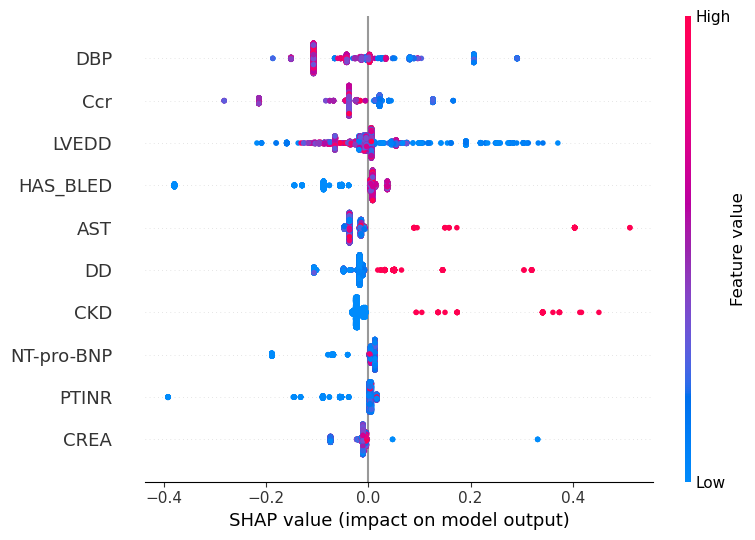

In [13]:
fig = plt.figure(figsize=(10,10))
shap.summary_plot(shap_values1.values[:,:,1],X_train,plot_type="dot",max_display=10,show=False)

In [14]:
def get_shap_top_n(shap_value,n):
    fea_imp = pd.DataFrame()
    fea_imp["feature_name"] = X_train.columns
    fea_imp["shap_value"] = np.sum(np.abs(shap_value.values[:,:,1]),axis=0)
    fea_imp.sort_values("shap_value",ascending=False,inplace=True)
    return fea_imp[0:n].feature_name.values

In [15]:
get_shap_top_n(shap_values1,20)

array(['DBP', 'Ccr', 'LVEDD', 'HAS_BLED', 'AST', 'DD', 'CKD',
       'NT-pro-BNP', 'PTINR', 'CREA', 'COPD', 'FBG',
       'Antihypertensive.agents', 'Ever.smoking', 'AF_category',
       'Ever.drinking', 'Diuretics', 'β.blocker', 'ACEI_ARB', 'Statins'],
      dtype=object)

In [131]:
dt_gs2 = GridSearchCV(dt,param_grid = dt_cv_parameters,cv=3, n_jobs=-1,scoring="roc_auc")
dt_gs2.fit(X_train,Y2_train)

# 性能测评
print("参数的最佳取值：:", dt_gs2.best_params_)
print("最佳模型得分:", dt_gs2.best_score_)
et = time.time()
print("耗时: {} s".format(et-st))


4410 fits failed out of a total of 13230.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4410 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/weiyuna/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/weiyuna/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 937, in fit
    super().fit(
  File "/Users/weiyuna/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 352, in fit
    criterion = CRITERIA_CLF[self.criterion](
KeyError: 'log_loss'

One or more of the test scores are non-finite: [0.54710924 0.54710924 0.54710924 ...       

参数的最佳取值：: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 3, 'max_features': 15, 'min_samples_leaf': 50, 'min_samples_split': 2, 'random_state': 123}
最佳模型得分: 0.6590061926190903
耗时: 11044.657474040985 s


In [16]:
dt2 = DecisionTreeClassifier(class_weight='balanced', criterion='entropy', max_depth=3,max_features=15, 
                             min_samples_leaf=50,min_samples_split=2,random_state=123).fit(X_train,Y2_train)

In [17]:
explainer2 = shap.TreeExplainer(dt2)
shap_values2 = explainer2(X_train)

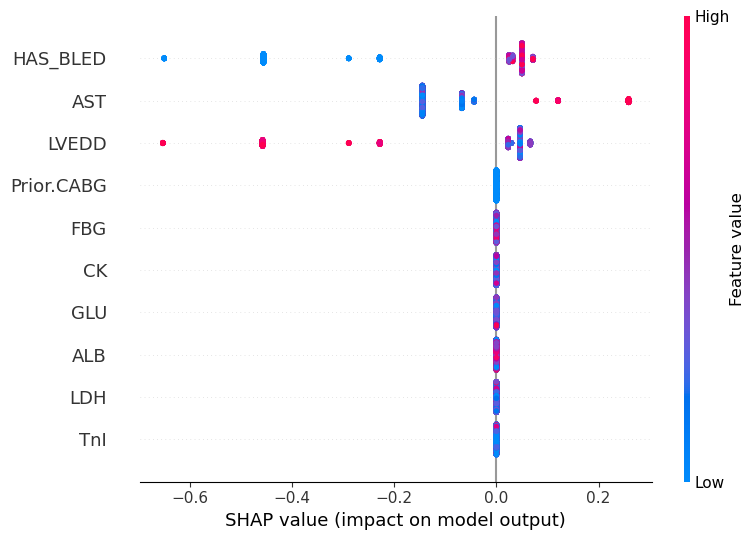

In [19]:
fig = plt.figure(figsize=(10,10))
shap.summary_plot(shap_values2.values[:,:,1],X_train,plot_type="dot",max_display=10,show=False)

In [20]:
get_shap_top_n(shap_values2,20)

array(['HAS_BLED', 'AST', 'LVEDD', 'AF_category', 'Ever.drinking',
       'Dabigatran', 'Rivaroxaban', 'Heparin', 'Anticoagulants',
       'Statins', 'ACEI_ARB', 'β.blocker', 'Diuretics', 'CCB',
       'Antihypertensive.agents', 'Ever.smoking', 'Heart.failure',
       'Angina', 'Antiplatelet.agents', 'Stroke'], dtype=object)

In [132]:
dt_gs3 = GridSearchCV(dt,param_grid = dt_cv_parameters,cv=3, n_jobs=-1,scoring="roc_auc")
dt_gs3.fit(X_train,Y3_train)

# 性能测评
print("参数的最佳取值：:", dt_gs3.best_params_)
print("最佳模型得分:", dt_gs3.best_score_)
et = time.time()
print("耗时: {} s".format(et-st))

参数的最佳取值：: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 5, 'max_features': 3, 'min_samples_leaf': 10, 'min_samples_split': 30, 'random_state': 123}
最佳模型得分: 0.8284513481333279
耗时: 11193.571079969406 s



4410 fits failed out of a total of 13230.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4410 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/weiyuna/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/weiyuna/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 937, in fit
    super().fit(
  File "/Users/weiyuna/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 352, in fit
    criterion = CRITERIA_CLF[self.criterion](
KeyError: 'log_loss'

One or more of the test scores are non-finite: [0.5362423 0.5362423 0.5362423 ...       nan

In [21]:
dt3 = DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=5,max_features=3, 
                             min_samples_leaf=10,min_samples_split=30,random_state=123).fit(X_train,Y3_train)

In [22]:
explainer3 = shap.TreeExplainer(dt3)
shap_values3 = explainer3(X_train)

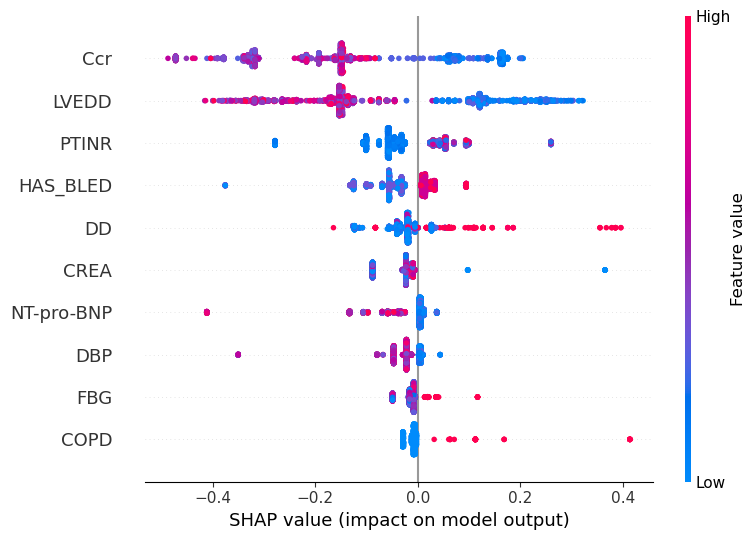

In [23]:
fig = plt.figure(figsize=(10,10))
shap.summary_plot(shap_values3.values[:,:,1],X_train,plot_type="dot",max_display=10,show=False)

In [24]:
get_shap_top_n(shap_values3,20)

array(['Ccr', 'LVEDD', 'PTINR', 'HAS_BLED', 'DD', 'CREA', 'NT-pro-BNP',
       'DBP', 'FBG', 'COPD', 'ALB', 'Ever.drinking', 'Ever.smoking',
       'AF_category', 'Angina', 'CCB', 'Diuretics', 'β.blocker',
       'ACEI_ARB', 'Statins'], dtype=object)